In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.layers import Embedding, LSTM, Dropout, Dense, GRU, SimpleRNN, Flatten

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [75]:
df = pd.read_csv('../data/train.csv')

In [76]:
texts = df['text'].astype(str)
relevance = df['positive']
X_train, X_test, y_train, y_test = train_test_split(texts, relevance, test_size=0.15, random_state=42, shuffle=True)

In [77]:
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [78]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [79]:
# Padding
maxlen = 100 
X_train = pad_sequences(sequences_train, maxlen=maxlen)
y_train = np.array(y_train)

X_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.array(y_test)


In [80]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [81]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Создадим функцию для тестирования моделей

In [82]:
def create_plot(history):
    plt.plot(
        history.history['loss'],
        label='Train loss'
        )
    plt.plot(
        history.history['val_loss'], 
        label='Val loss'
        )
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, 11))
    plt.legend()
    plt.show()

def calculate_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('Test accuracy is {}'.format(accuracy))
    print('Test precision is {}'.format(precision))
    print('Test recall is {}'.format(recall))
    print('Test f1 is {}'.format(f1))


def compile_fit_model(model, X_train, y_train, X_val, y_val):
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
        )
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        shuffle=False
        )
    return history

def test_model(model, X_train, y_train, X_test, y_test, X_val, y_val, threshold=0.5):
    """Trains and tests a given model.

    Args:
        model: The model to be trained and tested.
        X_train: Training features.
        y_train: Training labels.
        X_test: Test features.
        y_test: Test labels.
        X_val: Validation features.
        y_val: Validation labels.
        threshold: Threshold for converting probabilities to binary predictions.

    Returns:
        None
    """
        
    history = compile_fit_model(model, X_train, y_train, X_val, y_val)
    create_plot(history)
    y_pred = model.predict(X_test)
    y_pred = (y_pred > threshold).astype(int)
    calculate_metrics(y_pred, y_test)



Попробуем сначала реализовать простую модель

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6345 - loss: 0.6382 - val_accuracy: 0.8482 - val_loss: 0.3635
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8720 - loss: 0.3154 - val_accuracy: 0.8516 - val_loss: 0.3339
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9235 - loss: 0.2156 - val_accuracy: 0.8497 - val_loss: 0.3468
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9611 - loss: 0.1393 - val_accuracy: 0.8435 - val_loss: 0.3725
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9858 - loss: 0.0806 - val_accuracy: 0.8388 - val_loss: 0.4063
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9968 - loss: 0.0441 - val_accuracy: 0.8366 - val_loss: 0.4438
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9993 - loss: 0.0243 - val_accuracy: 0.8350 - val_loss: 0.4812


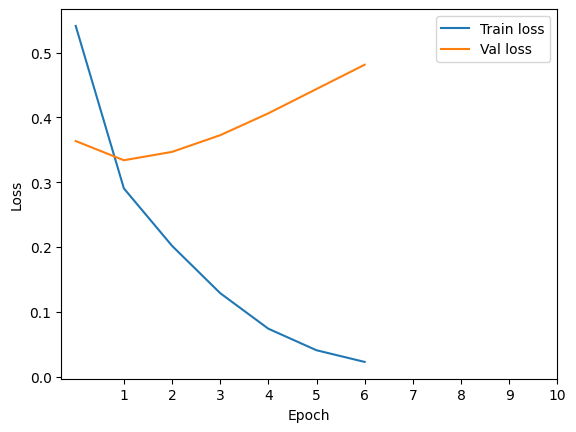

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy is 0.8626666666666667
Test precision is 0.8530157121135327
Test recall is 0.8820754716981132
Test f1 is 0.867302241690286


In [83]:
model_base = Sequential()
model_base.add(Embedding(max_words, 25))
model_base.add(Flatten())
model_base.add(Dense(1, activation='sigmoid'))

test_model(model_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает неплохое качество, при этом precision и recall довольно сбалансированы и близки друг к другу.

Попробуем далее усложнить модель.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6303 - loss: 0.6355 - val_accuracy: 0.8479 - val_loss: 0.3584
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8730 - loss: 0.3116 - val_accuracy: 0.8538 - val_loss: 0.3327
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9275 - loss: 0.2069 - val_accuracy: 0.8504 - val_loss: 0.3471
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9691 - loss: 0.1236 - val_accuracy: 0.8463 - val_loss: 0.3726
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.0641 - val_accuracy: 0.8413 - val_loss: 0.4061
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9985 - loss: 0.0325 - val_accuracy: 0.8372 - val_loss: 0.4515
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9998 - loss: 0.0178 - val_accuracy: 0.8366 - val_loss: 0.4819


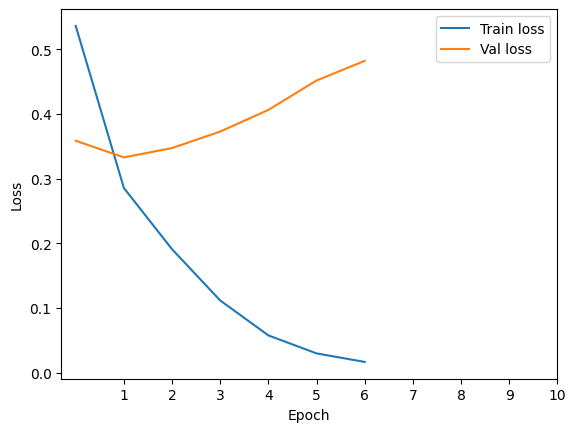

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy is 0.8632
Test precision is 0.8542407313357034
Test recall is 0.8815513626834381
Test f1 is 0.8676811968016508


In [84]:
model_base2 = Sequential()
model_base2.add(Embedding(max_words, 30))
model_base2.add(Flatten())
model_base2.add(Dense(1, activation='sigmoid'))

test_model(model_base2, X_train, y_train, X_test, y_test, X_val, y_val)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6401 - loss: 0.6243 - val_accuracy: 0.8491 - val_loss: 0.3500
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8818 - loss: 0.2953 - val_accuracy: 0.8507 - val_loss: 0.3368
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9428 - loss: 0.1776 - val_accuracy: 0.8413 - val_loss: 0.3614
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9838 - loss: 0.0857 - val_accuracy: 0.8413 - val_loss: 0.3942
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9975 - loss: 0.0369 - val_accuracy: 0.8372 - val_loss: 0.4388


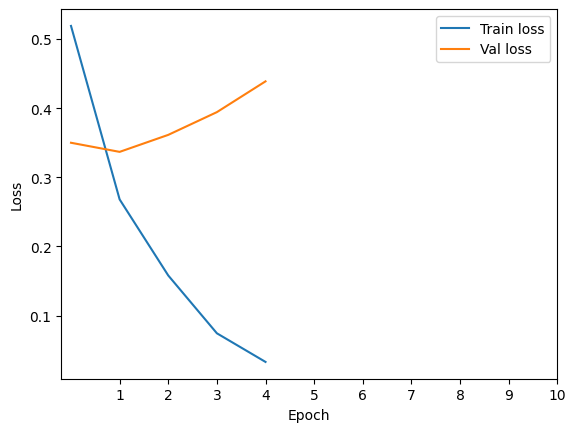

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy is 0.8533333333333334
Test precision is 0.8453713123092573
Test recall is 0.8710691823899371
Test f1 is 0.8580278781621063


In [85]:
model_base3 = Sequential()
model_base3.add(Embedding(max_words, 45))
model_base3.add(Flatten())
model_base3.add(Dense(1, activation='sigmoid'))

test_model(model_base3, X_train, y_train, X_test, y_test, X_val, y_val)

Модель становится лучше для 2 модели, и хуже для 3

Попробуем рекурентные нейросети, которые часто хорошо подходят для классификации текстов.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5992 - loss: 0.6418 - val_accuracy: 0.8021 - val_loss: 0.4433
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8302 - loss: 0.3923 - val_accuracy: 0.8225 - val_loss: 0.4103
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8798 - loss: 0.2983 - val_accuracy: 0.8312 - val_loss: 0.4105
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9178 - loss: 0.2168 - val_accuracy: 0.8074 - val_loss: 0.4576
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9476 - loss: 0.1609 - val_accuracy: 0.7908 - val_loss: 0.5269


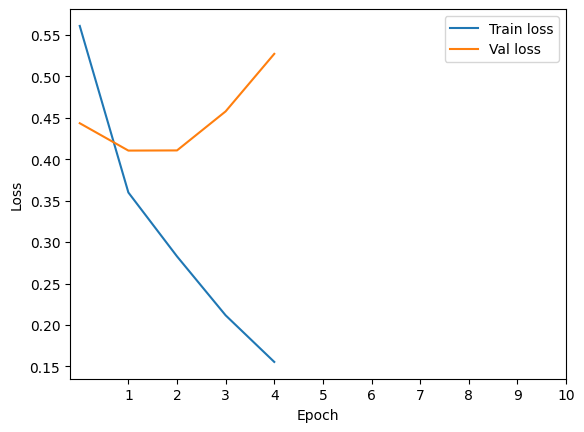

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test accuracy is 0.8069333333333333
Test precision is 0.7733148661126501
Test recall is 0.8778825995807128
Test f1 is 0.8222876779577811


In [86]:
model_rnn_base = Sequential()
model_rnn_base.add(Embedding(max_words, 15))
model_rnn_base.add(SimpleRNN(12))
model_rnn_base.add(Dense(1, activation='sigmoid'))

test_model(model_rnn_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает результат хуже

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5218 - loss: 0.6926 - val_accuracy: 0.7406 - val_loss: 0.5865
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7658 - loss: 0.5132 - val_accuracy: 0.8143 - val_loss: 0.4217
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8595 - loss: 0.3498 - val_accuracy: 0.8243 - val_loss: 0.4157
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9002 - loss: 0.2666 - val_accuracy: 0.8181 - val_loss: 0.4390
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9367 - loss: 0.1867 - val_accuracy: 0.7980 - val_loss: 0.5258


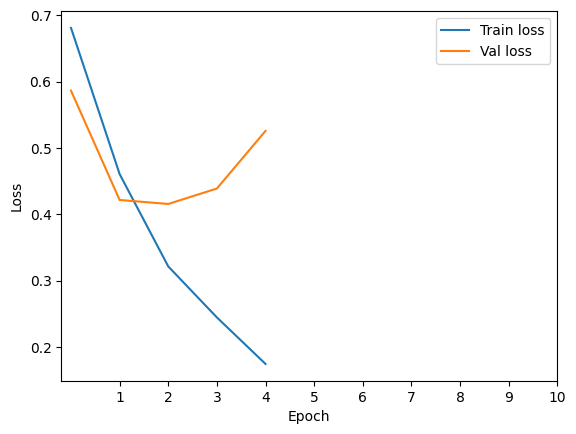

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test accuracy is 0.736
Test precision is 0.8097165991902834
Test recall is 0.6289308176100629
Test f1 is 0.7079646017699115


In [87]:
model_rnn2 = Sequential()
model_rnn2.add(Embedding(max_words, 15))
model_rnn2.add(SimpleRNN(12))
model_rnn2.add(Dropout(0.25))
model_rnn2.add(Dense(1, activation='sigmoid'))

test_model(model_rnn2, X_train, y_train, X_test, y_test, X_val, y_val)

Дропаут слой делает только хуже.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5501 - loss: 0.6762 - val_accuracy: 0.7930 - val_loss: 0.4798
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7783 - loss: 0.5016 - val_accuracy: 0.8203 - val_loss: 0.4216
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8400 - loss: 0.4047 - val_accuracy: 0.8124 - val_loss: 0.4289
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8736 - loss: 0.3346 - val_accuracy: 0.8206 - val_loss: 0.4332
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8987 - loss: 0.2787 - val_accuracy: 0.8058 - val_loss: 0.4975


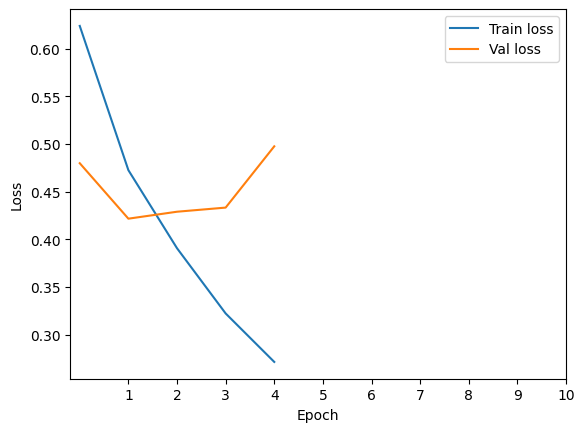

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test accuracy is 0.7941333333333334
Test precision is 0.784
Test recall is 0.8218029350104822
Test f1 is 0.8024564994882293


In [88]:
model_rnn3 = Sequential()
model_rnn3.add(Embedding(max_words, 15))
model_rnn3.add(SimpleRNN(12))
model_rnn3.add(Dropout(0.5))
model_rnn3.add(Dense(1, activation='sigmoid'))

test_model(model_rnn3, X_train, y_train, X_test, y_test, X_val, y_val)

Попробуем модель GRU

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.6142 - loss: 0.6327 - val_accuracy: 0.8231 - val_loss: 0.3983
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.8478 - loss: 0.3630 - val_accuracy: 0.8428 - val_loss: 0.3631
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.8906 - loss: 0.2949 - val_accuracy: 0.8397 - val_loss: 0.3794
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9072 - loss: 0.2627 - val_accuracy: 0.8381 - val_loss: 0.3883
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9186 - loss: 0.2390 - val_accuracy: 0.8341 - val_loss: 0.4102


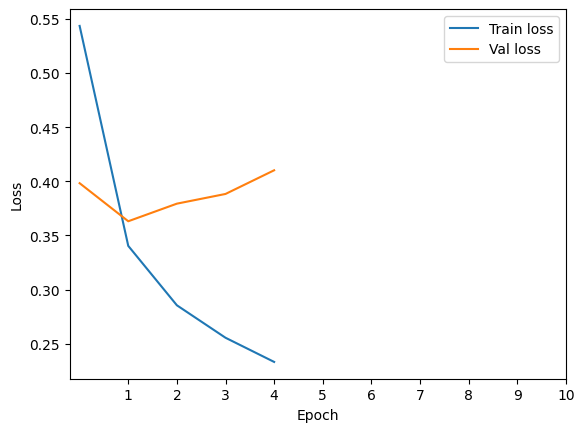

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Test accuracy is 0.8293333333333334
Test precision is 0.7948837209302325
Test recall is 0.8957023060796646
Test f1 is 0.84228684080828


In [89]:
model_gru_base = Sequential()
model_gru_base.add(Embedding(max_words, 15))
model_gru_base.add(GRU(12))
model_gru_base.add(Dropout(0.5))
model_gru_base.add(Dense(1, activation='sigmoid'))

test_model(model_gru_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает метрики хуже, чем базовая модель

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.6745 - loss: 0.5780 - val_accuracy: 0.8444 - val_loss: 0.3553
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.8732 - loss: 0.3117 - val_accuracy: 0.8428 - val_loss: 0.3546
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.9077 - loss: 0.2464 - val_accuracy: 0.8334 - val_loss: 0.3903
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9215 - loss: 0.2102 - val_accuracy: 0.8272 - val_loss: 0.4019
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.9198 - loss: 0.2049 - val_accuracy: 0.8403 - val_loss: 0.4211


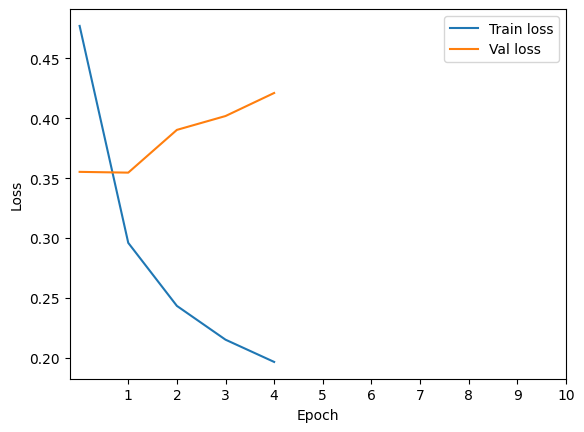

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test accuracy is 0.856
Test precision is 0.8657754010695187
Test recall is 0.8485324947589099
Test f1 is 0.8570672313393329


In [90]:
model_lstm_base = Sequential()
model_lstm_base.add(Embedding(max_words, 15))
model_lstm_base.add(LSTM(12))
model_lstm_base.add(Dense(1, activation='sigmoid'))

test_model(model_lstm_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель также хуже, чем базовая, еще и обучается дольше

Ситуация аналогична GRU

In [91]:
model_lstm2 = Sequential()
model_lstm2.add(Embedding(max_words, 15))
model_lstm2.add(LSTM(6))
model_lstm2.add(Dense(1, activation='sigmoid'))

test_model(model_lstm2, X_train, y_train, X_test, y_test, X_val, y_val)

Epoch 1/10
479/565 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6484 - loss: 0.6255

KeyboardInterrupt: 

Снижение числа нейронов слоя LSTM не дает нужного эффекта, модель хуже чем базовая, однако обучается дольше.

Попробуем несколько слоев LSTM

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.6666 - loss: 0.6032 - val_accuracy: 0.8071 - val_loss: 0.4414
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.8417 - loss: 0.3978 - val_accuracy: 0.8353 - val_loss: 0.3824
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.8817 - loss: 0.3126 - val_accuracy: 0.8476 - val_loss: 0.3667
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9096 - loss: 0.2625 - val_accuracy: 0.8457 - val_loss: 0.3908
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9208 - loss: 0.2276 - val_accuracy: 0.8359 - val_loss: 0.4516


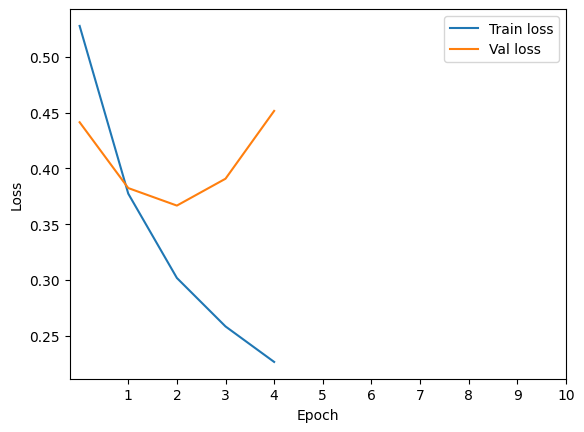

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
Test accuracy is 0.8130666666666667
Test precision is 0.7746927628584434
Test recall is 0.8920335429769392
Test f1 is 0.8292326431181487


In [20]:
model_lstm3 = Sequential()
model_lstm3.add(Embedding(max_words, 30))
model_lstm3.add(LSTM(6, return_sequences=True))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(LSTM(6))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(1, activation='sigmoid'))

test_model(model_lstm3, X_train, y_train, X_test, y_test, X_val, y_val)

Качество выросло незаметно

Попробуем полносвязную нейросеть

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5261 - loss: 0.6872 - val_accuracy: 0.7914 - val_loss: 0.5035
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7991 - loss: 0.4959 - val_accuracy: 0.8187 - val_loss: 0.4174
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8833 - loss: 0.3429 - val_accuracy: 0.8303 - val_loss: 0.4419
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9324 - loss: 0.2256 - val_accuracy: 0.8316 - val_loss: 0.6008
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9606 - loss: 0.1538 - val_accuracy: 0.8275 - val_loss: 0.7211


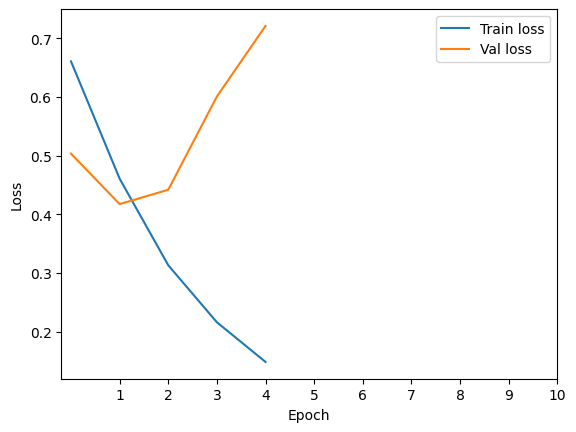

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test accuracy is 0.7976
Test precision is 0.8100377765785213
Test recall is 0.7866876310272537
Test f1 is 0.7981919702206859


In [21]:
model_fully = Sequential()
model_fully.add(Embedding(max_words, 30))
model_fully.add(Flatten())
model_fully.add(Dense(10, activation='relu'))
model_fully.add(Dropout(0.5))
model_fully.add(Dense(10, activation='relu'))
model_fully.add(Dropout(0.5))
model_fully.add(Dense(1, activation='sigmoid'))

test_model(model_fully, X_train, y_train, X_test, y_test, X_val, y_val)

Переобучение и наивный прогноз

Проверим модель на тесте

In [62]:
df_test = pd.read_csv('../data/test.csv')

In [56]:
texts_test = df_test['text'].astype(str)
labels_test = df_test['positive']

In [57]:
sequences_test = tokenizer.texts_to_sequences(texts_test) #Уже обученный на трейн текстах токенизатор

X_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.array(labels_test)

In [58]:
y_pred = model_base2.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [59]:
calculate_metrics(y_pred, y_test)

Test accuracy is 0.85464
Test precision is 0.8444444444444444
Test recall is 0.86944
Test f1 is 0.8567599527000394


Модель показала неплохой результат на тесте, по нашей целевой метрике Accuracy тоже неплохо = 0.855,<br><br/>F1 также довольно хороший = 0.857

В итоге наилучшей моделью оказалась простая модель нейросети, состоящая из слоя эмбеддинга и выходного слоя.


Сохраним эту модель

In [61]:
model_base2.save('../model_params/custom_nn_sentiment.h5')

Сохраним токенизатор


In [ ]:
tokenizer_json = tokenizer.to_json()
with open('../tokenizers/sentiment_tokenizer.json', 'w') as f:
    f.write(tokenizer_json)